In [1]:
import pandas as pd

# Read data
data = pd.read_csv("sonar.csv", header=None)
X = data.iloc[:, 0:60]
y = data.iloc[:, 60]

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
print(encoder.classes_)

['M' 'R']


In [7]:
import torch

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [8]:
import torch.nn as nn

class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    
# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

11161
11041


In [19]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [ ]:
from sklearn.model_selection import StratifiedKFold
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(X, y):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X[train], y[train], X[test], y[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores.append(acc)

# evaluate the model
acc = np.mean(cv_scores)
std = np.std(cv_scores)
print("Model accuracy: %.2f%% (+/- %.2f%%)" % (acc*100, std*100))

In [21]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Accuracy (wide): 0.86
Accuracy (wide): 0.79
Accuracy (wide): 0.83
Accuracy (wide): 0.76
Accuracy (wide): 0.83
Accuracy (deep): 0.83
Accuracy (deep): 0.83
Accuracy (deep): 0.86
Accuracy (deep): 0.86
Accuracy (deep): 0.86
Wide: 81.38% (+/- 3.52%)
Deep: 84.83% (+/- 1.69%)


In [36]:
# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Retrain a deep model
Final model accuracy: 82.54%


In [26]:
model.eval()
threshold = 0.68
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        y_pred = (y_pred > threshold).float() # 0.0 or 1.0
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[3.730e-02 2.810e-02 2.320e-02 2.250e-02 1.790e-02 7.330e-02 8.410e-02
 1.031e-01 9.930e-02 8.020e-02 1.564e-01 2.565e-01 2.624e-01 1.179e-01
 5.970e-02 1.563e-01 2.241e-01 3.586e-01 1.792e-01 3.256e-01 6.079e-01
 6.988e-01 8.391e-01 8.553e-01 7.710e-01 6.215e-01 5.736e-01 4.402e-01
 4.056e-01 4.411e-01 5.130e-01 5.965e-01 7.272e-01 6.539e-01 5.902e-01
 5.393e-01 4.897e-01 4.081e-01 4.145e-01 6.003e-01 7.196e-01 6.633e-01
 6.287e-01 4.087e-01 3.212e-01 2.518e-01 1.482e-01 9.880e-02 3.170e-02
 2.690e-02 6.600e-03 8.000e-04 4.500e-03 2.400e-03 6.000e-04 7.300e-03
 9.600e-03 5.400e-03 8.500e-03 6.000e-03] -> [0.] (expected [1.])
[0.0412 0.1135 0.0518 0.0232 0.0646 0.1124 0.1787 0.2407 0.2682 0.2058
 0.1546 0.2671 0.3141 0.2904 0.3531 0.5079 0.4639 0.1859 0.4474 0.4079
 0.54   0.4786 0.4332 0.6113 0.5091 0.4606 0.7243 0.8987 0.8826 0.9201
 0.8005 0.6033 0.212  0.2866 0.4033 0.2803 0.3087 0.355  0.2545 0.1432
 0.5869 0.6431 0.5826 0.4286 0.4894 0.5777 0.4315 0.264  0.1794 0.0772
 0.0798 0.0

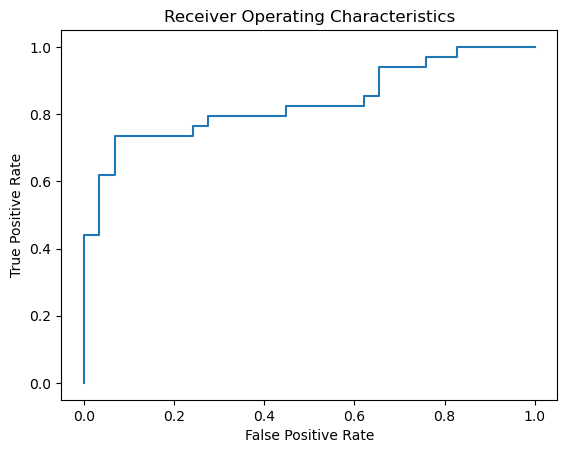

In [37]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

with torch.no_grad():
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()